Deep Learning Models -- A collection of various deep learning architectures, models, and tips for TensorFlow and PyTorch in Jupyter Notebooks.
- Author: Sebastian Raschka
- GitHub Repository: https://github.com/rasbt/deeplearning-models

# Bidirectional Multi-layer RNN with LSTM with Own Dataset in CSV Format (AG News)

Dataset Description

```
AG's News Topic Classification Dataset

Version 3, Updated 09/09/2015


ORIGIN

AG is a collection of more than 1 million news articles. News articles have been gathered from more than 2000  news sources by ComeToMyHead in more than 1 year of activity. ComeToMyHead is an academic news search engine which has been running since July, 2004. The dataset is provided by the academic community for research purposes in data mining (clustering, classification, etc), information retrieval (ranking, search, etc), xml, data compression, data streaming, and any other non-commercial activity. For more information, please refer to the link http://www.di.unipi.it/~gulli/AG_corpus_of_news_articles.html .

The AG's news topic classification dataset is constructed by Xiang Zhang (xiang.zhang@nyu.edu) from the dataset above. It is used as a text classification benchmark in the following paper: Xiang Zhang, Junbo Zhao, Yann LeCun. Character-level Convolutional Networks for Text Classification. Advances in Neural Information Processing Systems 28 (NIPS 2015).


DESCRIPTION

The AG's news topic classification dataset is constructed by choosing 4 largest classes from the original corpus. Each class contains 30,000 training samples and 1,900 testing samples. The total number of training samples is 120,000 and testing 7,600.

The file classes.txt contains a list of classes corresponding to each label.

The files train.csv and test.csv contain all the training samples as comma-sparated values. There are 3 columns in them, corresponding to class index (1 to 4), title and description. The title and description are escaped using double quotes ("), and any internal double quote is escaped by 2 double quotes (""). New lines are escaped by a backslash followed with an "n" character, that is "\n".
```

In [1]:
!pip install -q IPython
!pip install -q ipykernel
!pip install -q watermark
!pip install -q matplotlib
!pip install -q sklearn
!pip install -q pandas
!pip install -q pydot
!pip install -q hiddenlayer
!pip install -q graphviz
!pip install -q gdown

In [2]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch


import torch
import torch.nn.functional as F
from torchtext import data
from torchtext import datasets
import time
import random
import pandas as pd
import numpy as np

torch.backends.cudnn.deterministic = True

Sebastian Raschka 

CPython 3.6.9
IPython 5.5.0

torch 1.5.1+cu101


## General Settings

In [3]:
RANDOM_SEED = 123
torch.manual_seed(RANDOM_SEED)

VOCABULARY_SIZE = 5000
LEARNING_RATE = 1e-3
BATCH_SIZE = 128
NUM_EPOCHS = 50
DROPOUT = 0.5
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

EMBEDDING_DIM = 128
BIDIRECTIONAL = True
HIDDEN_DIM = 256
NUM_LAYERS = 2
OUTPUT_DIM = 4

## Dataset

The AG News dataset is available from Xiang Zhang's Google Drive folder at

https://drive.google.com/drive/u/0/folders/0Bz8a_Dbh9Qhbfll6bVpmNUtUcFdjYmF2SEpmZUZUcVNiMUw1TWN6RDV3a0JHT3kxLVhVR2M

From the Google Drive folder, download the file 

- `ag_news_csv.tar.gz`

In [4]:
!gdown -O ag_news_csv.tar.gz --id 0Bz8a_Dbh9QhbUDNpeUdjb0wxRms

Downloading...
From: https://drive.google.com/uc?id=0Bz8a_Dbh9QhbUDNpeUdjb0wxRms
To: /content/ag_news_csv.tar.gz
11.8MB [00:00, 54.9MB/s]


In [8]:
!tar xvzf  ag_news_csv.tar.gz

ag_news_csv/
ag_news_csv/train.csv
ag_news_csv/test.csv
ag_news_csv/classes.txt
ag_news_csv/readme.txt


In [9]:
!cat ag_news_csv/classes.txt

World
Sports
Business
Sci/Tech


Check that the dataset looks okay:

In [10]:
df = pd.read_csv('ag_news_csv/train.csv', header=None, index_col=None)
df.columns = ['classlabel', 'title', 'content']
df['classlabel'] = df['classlabel']-1
df.head()

,classlabel,title,content
0,2,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,2,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,2,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,2,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,2,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [11]:
np.unique(df['classlabel'].values)

array([0, 1, 2, 3])

In [12]:
np.bincount(df['classlabel'])

array([30000, 30000, 30000, 30000])

In [13]:
df[['classlabel', 'content']].to_csv('ag_news_csv/train_prepocessed.csv', index=None)

In [14]:
df = pd.read_csv('ag_news_csv/test.csv', header=None, index_col=None)
df.columns = ['classlabel', 'title', 'content']
df['classlabel'] = df['classlabel']-1
df.head()

,classlabel,title,content
0,2,Fears for T N pension after talks,Unions representing workers at Turner Newall...
1,3,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."
2,3,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...
3,3,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...
4,3,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...


In [15]:
np.unique(df['classlabel'].values)

array([0, 1, 2, 3])

In [16]:
np.bincount(df['classlabel'])

array([1900, 1900, 1900, 1900])

In [17]:
df[['classlabel', 'content']].to_csv('ag_news_csv/test_prepocessed.csv', index=None)

In [18]:
del df

Define the Label and Text field formatters:

In [19]:
TEXT = data.Field(sequential=True,
                  tokenize='spacy',
                  include_lengths=True) # necessary for packed_padded_sequence

LABEL = data.LabelField(dtype=torch.float)


# If you get an error [E050] Can't find model 'en'
# you need to run the following on your command line:
#  python -m spacy download en

Process the dataset:

In [20]:
fields = [('classlabel', LABEL), ('content', TEXT)]

train_dataset = data.TabularDataset(
    path="ag_news_csv/train_prepocessed.csv", format='csv',
    skip_header=True, fields=fields)

test_dataset = data.TabularDataset(
    path="ag_news_csv/test_prepocessed.csv", format='csv',
    skip_header=True, fields=fields)

Split the training dataset into training and validation:

In [21]:
train_data, valid_data = train_dataset.split(
    split_ratio=[0.95, 0.05],
    random_state=random.seed(RANDOM_SEED))

print(f'Num Train: {len(train_data)}')
print(f'Num Valid: {len(valid_data)}')

Num Train: 114000
Num Valid: 6000


Build the vocabulary based on the top "VOCABULARY_SIZE" words:

In [22]:
TEXT.build_vocab(train_data,
                 max_size=VOCABULARY_SIZE,
                 vectors='glove.6B.100d',
                 unk_init=torch.Tensor.normal_)

LABEL.build_vocab(train_data)

print(f'Vocabulary size: {len(TEXT.vocab)}')
print(f'Number of classes: {len(LABEL.vocab)}')

.vector_cache/glove.6B.zip: 862MB [06:29, 2.22MB/s]                          
100%|█████████▉| 398407/400000 [00:15<00:00, 25295.52it/s]

Vocabulary size: 5002
Number of classes: 4


In [23]:
list(LABEL.vocab.freqs)[-10:]

['1', '3', '0', '2']

The TEXT.vocab dictionary will contain the word counts and indices. The reason why the number of words is VOCABULARY_SIZE + 2 is that it contains to special tokens for padding and unknown words: `<unk>` and `<pad>`.

Make dataset iterators:

In [24]:
train_loader, valid_loader, test_loader = data.BucketIterator.splits(
    (train_data, valid_data, test_dataset), 
    batch_size=BATCH_SIZE,
    sort_within_batch=True, # necessary for packed_padded_sequence
    sort_key=lambda x: len(x.content),
    device=DEVICE)

Testing the iterators (note that the number of rows depends on the longest document in the respective batch):

In [25]:
print('Train')
for batch in train_loader:
    print(f'Text matrix size: {batch.content[0].size()}')
    print(f'Target vector size: {batch.classlabel.size()}')
    break
    
print('\nValid:')
for batch in valid_loader:
    print(f'Text matrix size: {batch.content[0].size()}')
    print(f'Target vector size: {batch.classlabel.size()}')
    break
    
print('\nTest:')
for batch in test_loader:
    print(f'Text matrix size: {batch.content[0].size()}')
    print(f'Target vector size: {batch.classlabel.size()}')
    break

Train
Text matrix size: torch.Size([35, 128])
Target vector size: torch.Size([128])

Valid:
Text matrix size: torch.Size([17, 128])
Target vector size: torch.Size([128])

Test:
Text matrix size: torch.Size([16, 128])
Target vector size: torch.Size([128])


## Model

In [26]:
import torch.nn as nn


class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, bidirectional, hidden_dim, num_layers, output_dim, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx=pad_idx)
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim,
                           num_layers=num_layers,
                           bidirectional=bidirectional, 
                           dropout=dropout)
        self.fc1 = nn.Linear(hidden_dim * num_layers, 64)
        self.fc2 = nn.Linear(64, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_length):

        embedded = self.dropout(self.embedding(text))
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_length)
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        # output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        hidden = self.fc1(hidden)
        hidden = self.dropout(hidden)
        hidden = self.fc2(hidden)
        return hidden

In [27]:
INPUT_DIM = len(TEXT.vocab)

PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

torch.manual_seed(RANDOM_SEED)
model = RNN(INPUT_DIM, EMBEDDING_DIM, BIDIRECTIONAL, HIDDEN_DIM, NUM_LAYERS, OUTPUT_DIM, DROPOUT, PAD_IDX)
model = model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

/usr/local/lib/python3.6/dist-packages/torch/onnx/symbolic_opset9.py:1310: UserWarning: Dropout is a training op and should not be exported in inference mode. Make sure to call eval() on the model, and to export it with param training=False.
  warnings.warn("Dropout is a training op and should not be exported in inference mode. "
/usr/local/lib/python3.6/dist-packages/torch/onnx/symbolic_opset9.py:1586: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  "or define the initial states (h0/c0) as inputs of the model. ")
/usr/local/lib/python3.6/dist-packages/torch/onnx/symbolic_helper.py:176: UserWarning: ONNX export failed on RNN/GRU/LSTM because dropout in training mode not supported
  warnings.warn("ONNX export failed on " + op + " because " + m

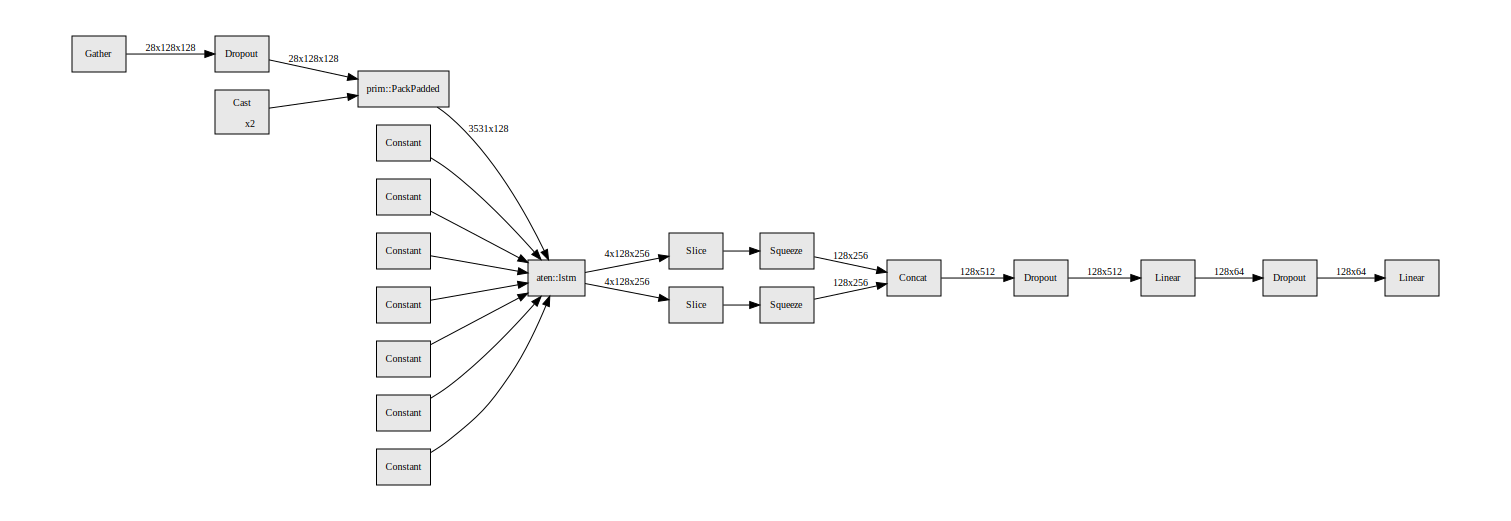

In [29]:
import hiddenlayer as hl
batch = next(iter(train_loader))
hl.build_graph(model, batch.content)

## Training

In [30]:
def compute_accuracy(model, data_loader, device):
    model.eval()
    correct_pred, num_examples = 0, 0
    with torch.no_grad():
        for batch_idx, batch_data in enumerate(data_loader):
            text, text_lengths = batch_data.content
            logits = model(text, text_lengths)
            _, predicted_labels = torch.max(logits, 1)
            num_examples += batch_data.classlabel.size(0)
            correct_pred += (predicted_labels.long() == batch_data.classlabel.long()).sum()
        return correct_pred.float()/num_examples * 100

In [ ]:
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    model.train()
    for batch_idx, batch_data in enumerate(train_loader):
        
        text, text_lengths = batch_data.content
        
        ### FORWARD AND BACK PROP
        logits = model(text, text_lengths)
        cost = F.cross_entropy(logits, batch_data.classlabel.long())
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} | '
                   f'Cost: {cost:.4f}')

    with torch.set_grad_enabled(False):
        print(f'training accuracy: '
              f'{compute_accuracy(model, train_loader, DEVICE):.2f}%'
              f'\nvalid accuracy: '
              f'{compute_accuracy(model, valid_loader, DEVICE):.2f}%')
        
    print(f'Time elapsed: {(time.time() - start_time)/60:.2f} min')
    
print(f'Total Training Time: {(time.time() - start_time)/60:.2f} min')
print(f'Test accuracy: {compute_accuracy(model, test_loader, DEVICE):.2f}%')

Epoch: 001/050 | Batch 000/891 | Cost: 1.3865
Epoch: 001/050 | Batch 050/891 | Cost: 1.2066
Epoch: 001/050 | Batch 100/891 | Cost: 1.1692
Epoch: 001/050 | Batch 150/891 | Cost: 0.9862
Epoch: 001/050 | Batch 200/891 | Cost: 0.9992
Epoch: 001/050 | Batch 250/891 | Cost: 0.8206
Epoch: 001/050 | Batch 300/891 | Cost: 0.7449
Epoch: 001/050 | Batch 350/891 | Cost: 0.6300
Epoch: 001/050 | Batch 400/891 | Cost: 0.7949
Epoch: 001/050 | Batch 450/891 | Cost: 0.5924
Epoch: 001/050 | Batch 500/891 | Cost: 0.6359
Epoch: 001/050 | Batch 550/891 | Cost: 0.9071
Epoch: 001/050 | Batch 600/891 | Cost: 0.5533
Epoch: 001/050 | Batch 650/891 | Cost: 0.6460
Epoch: 001/050 | Batch 700/891 | Cost: 0.5671
Epoch: 001/050 | Batch 750/891 | Cost: 0.4732
Epoch: 001/050 | Batch 800/891 | Cost: 0.4709
Epoch: 001/050 | Batch 850/891 | Cost: 0.4538
training accuracy: 86.64%
valid accuracy: 85.98%
Time elapsed: 44.74 min
Epoch: 002/050 | Batch 000/891 | Cost: 0.5731
Epoch: 002/050 | Batch 050/891 | Cost: 0.4066
Epoch: 

## Evaluation

Evaluating on some new text that has been collected from recent news articles and is not part of the training or test sets.

In [ ]:
import spacy
nlp = spacy.load('en')


map_dictionary = {
    0: "World",
    1: "Sports",
    2: "Business",
    3:"Sci/Tech",
}


def predict_class(model, sentence, min_len=4):
    # Somewhat based on
    # https://github.com/bentrevett/pytorch-sentiment-analysis/
    # blob/master/5%20-%20Multi-class%20Sentiment%20Analysis.ipynb
    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    if len(tokenized) < min_len:
        tokenized += ['<pad>'] * (min_len - len(tokenized))
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(DEVICE)
    tensor = tensor.unsqueeze(1)
    length_tensor = torch.LongTensor(length)
    preds = model(tensor, length_tensor)
    preds = torch.softmax(preds, dim=1)
    
    proba, class_label = preds.max(dim=1)
    return proba.item(), class_label.item()

In [ ]:
text = """
The windfall follows a tender offer by Z Holdings, which is controlled by SoftBank’s domestic wireless unit, 
for half of Zozo’s shares this month.
"""

proba, pred_label = predict_class(model, text)

print(f'Class Label: {pred_label} -> {map_dictionary[pred_label]}')
print(f'Probability: {proba}')

In [ ]:
text = """
EU data regulator issues first-ever sanction of an EU institution, 
against the European parliament over its use of US-based NationBuilder to process voter data 
"""

proba, pred_label = predict_class(model, text)

print(f'Class Label: {pred_label} -> {map_dictionary[pred_label]}')
print(f'Probability: {proba}')

In [ ]:
text = """
LG announces CEO Jo Seong-jin will be replaced by Brian Kwon Dec. 1, amid 2020 
leadership shakeup and LG smartphone division's 18th straight quarterly loss
"""

proba, pred_label = predict_class(model, text)

print(f'Class Label: {pred_label} -> {map_dictionary[pred_label]}')
print(f'Probability: {proba}')

In [ ]:
%watermark -iv